# NMF Practical Work

**Roland Badeau - Notebook code by Umut Simsekli** 

Telecom Paris - TSIA 206

Made by Bruno Pons and Agustín Noel Coitinho Ramírez.

### Imports:

In [25]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
# ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display

<Figure size 640x480 with 0 Axes>

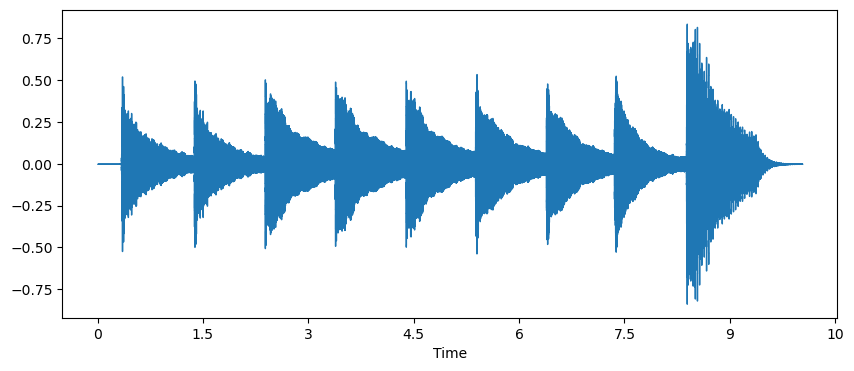

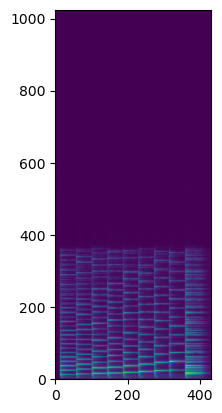

In [14]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
# Compute magnitude spectrogram
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


#### Question 1

We would like to solve the problem:

$ C_\beta(X || WH) = \sum^I_{i=1} \sum^J_{j=1} d_\beta (x_{ij} || \hat{x}_{ij})$

$ (W^*, H^*) = arg min_{W \geq 0, H \geq 0} C_\beta(X || WH)$

where $x_{ij}$ is an element of $X\in \mathbb{R}_+^{I \times J}$, that is the non-negative data matrix, and $W \in \mathbb{R}_+^{I \times K}$ and $H \in \mathbb{R}_+^{K \times J} $ are the unknown non-negative factor matrices. We also define $\hat{x}_{ij} = \sum _k w_{ik} h_{kj}$. The cost function that we are minimizing is called the $\beta$-divergence, which is defined as follows:

$d_{\beta} (x || \hat{x}) = \frac{x^\beta}{\beta(\beta-1)} - \frac{x \hat{x}^{\beta-1}}{\beta -1} + \frac{\hat{x}^\beta}{\beta}$

Now, we are going to derive the multiplication update rules (MUR) algorithm.

This algorithm is based in gradient descent, more generally we will have something like this:

$\{W,H\}_{k+1} = \{W,H\}_k - \eta \circ \nabla C_\beta(X || WH)$

Where this $\circ$ refers to the Hadamard product (element by element) and $\eta$ represents a matrix of learning rates.

With that approach we can write down the following scheme that is called block-coordinate descent:

$ H \leftarrow H - \eta _H \circ \nabla _H C_\beta(X, WH) $

$ W \leftarrow W - \eta _W \circ \nabla _W C_\beta(X,WH) $

Where $\eta _W \in \mathbb{R}_+^{M \times K}$ and $\eta _H \in \mathbb{R}_+^{K \times N}$.

By computing $\nabla _H C_\beta(X || WH)$ and $\nabla _W C_\beta(X || WH)$ we obtain:

$\nabla _H C_\beta(X || WH) = W^T (WH)^{\beta-1} - W^T (X \circ WH^{\beta-2}) $

$\nabla _W C_\beta(X || WH) = (WH)^{\beta - 1} H^T - (X \circ (WH)^{\beta-2})H^T$

In traditional gradient descent, the learning rates $\eta _H$ and $\eta _W$ are typically positive. However, the latter can lead to negative elements due to the subtraction involved in the update rules, which goes against the non-negativity constraint. To address this issue, Lee and Seung proposed a solution by introducing data-adaptive learning rates that prevent the occurrence of negative elements. The approach involves defining the learning rates in a way that eliminates any subtraction from the update rule. For the matrices $H$ and $W$, this can be achieved by setting:

$\eta _H = \frac {H}{W^T (WH)^{\beta-1}}$

$\eta _W = \frac {W}{(WH)^{\beta - 1} H^T}$

Where this $/$ denotes element-wise division.

In such way, we can find the update rules for the algorithm:

$H \leftarrow H \circ \frac{W^T(X \circ (WH)^{\beta-2})}{W^T(WH)^{\beta -1}}$

$W \leftarrow W \circ \frac{(X \circ (WH)^{\beta -2})H^T}{(WH)^{\beta -1}H^T}$

This explanation was based on the paper "Detailed derivation of multiplicative update rules for NMF" by Juan José Burred (2014).

In [15]:
# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)

### Functions implementation:

In [16]:
# Implement MUR for NMF with beta-divergence 
def MUR_NMF(X, k, beta, max_iter=100):
    # Initialize W and H
    W = np.random.rand(X.shape[0], k)
    H = np.random.rand(k, X.shape[1])
    eps = 1e-9
    # Iteration
    for i in range(max_iter):
        # Update W
        # W = W * np.dot((X * (np.dot(W, H) + 1e-09 )**(beta-2)), H.T) / (np.dot((np.dot(W, H))**(beta-1), H.T) + 1e-9)
        W = W * ( np.dot((X * np.power(np.dot(W, H) + eps, beta-2)), H.T) / (np.dot( np.power(np.dot(W, H) + eps , beta-1), H.T) + eps) )
        # Update H
        # H = H * (np.dot(W.T, (X * (np.dot(W, H) + 1e-09)**(beta-2))) / (np.dot(W.T, (np.dot(W, H))**(beta-1)) + eps) )
        H = H * ( np.dot(W.T, (X * np.power(np.dot(W, H) + eps, beta-2))) / (np.dot(W.T, np.power(np.dot(W, H) + eps, beta-1)) + eps) )
    return W, H


# Implement Wiener filtering
def Wiener_filtering(X, W, H):
    K = W.shape[1]
    lt = []
    for i in range(K):
        x_i = np.dot(W[:,i].reshape(-1,1), H[i,:].reshape(1,-1))
        lt.append(x_i)
    # Transform list into numpy matrix
    X_filtered = np.array(lt)
    X_filtered = X * X_filtered / (np.dot(W, H) + 1e-09 )
    return X_filtered

### Analysis modificating the parameters:

1. Setting $\beta = 1$ (Kullback-Leibler divergence), STFT windowed signal size = 2048 with STFT hop size = 512, and comparing results changing the number of columns of W = {2,3}.

In [17]:
# Compute de W, H factorization
W, H = MUR_NMF(X, 2, 1, max_iter=100)

# Compute the filtered spectrogram
X_filtered = Wiener_filtering(Xstft, W, H)

# Compute de W, H factorization
W, H = MUR_NMF(X, 3, 1, max_iter=100)

# Compute the filtered spectrogram
X_filtered1 = Wiener_filtering(Xstft, W, H)

y_filtered = []
# Compute the inverse stft for each signal
for i in range(X_filtered.shape[0]):
    y_filtered.append(librosa.istft(X_filtered[i]))
y_filtered = np.array(y_filtered)

y_filtered1 = []
# Compute the inverse stft for each signal
for i in range(X_filtered1.shape[0]):
    y_filtered1.append(librosa.istft(X_filtered1[i]))
y_filtered1 = np.array(y_filtered1)

<Figure size 640x480 with 0 Axes>

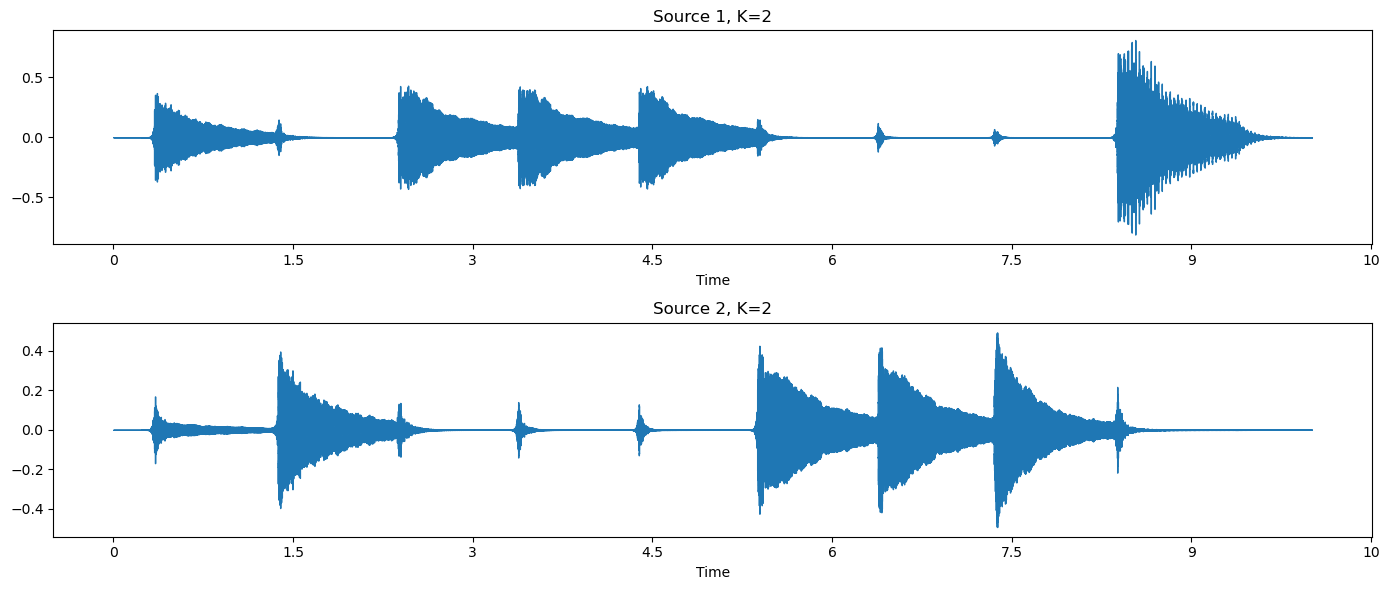

<Figure size 640x480 with 0 Axes>

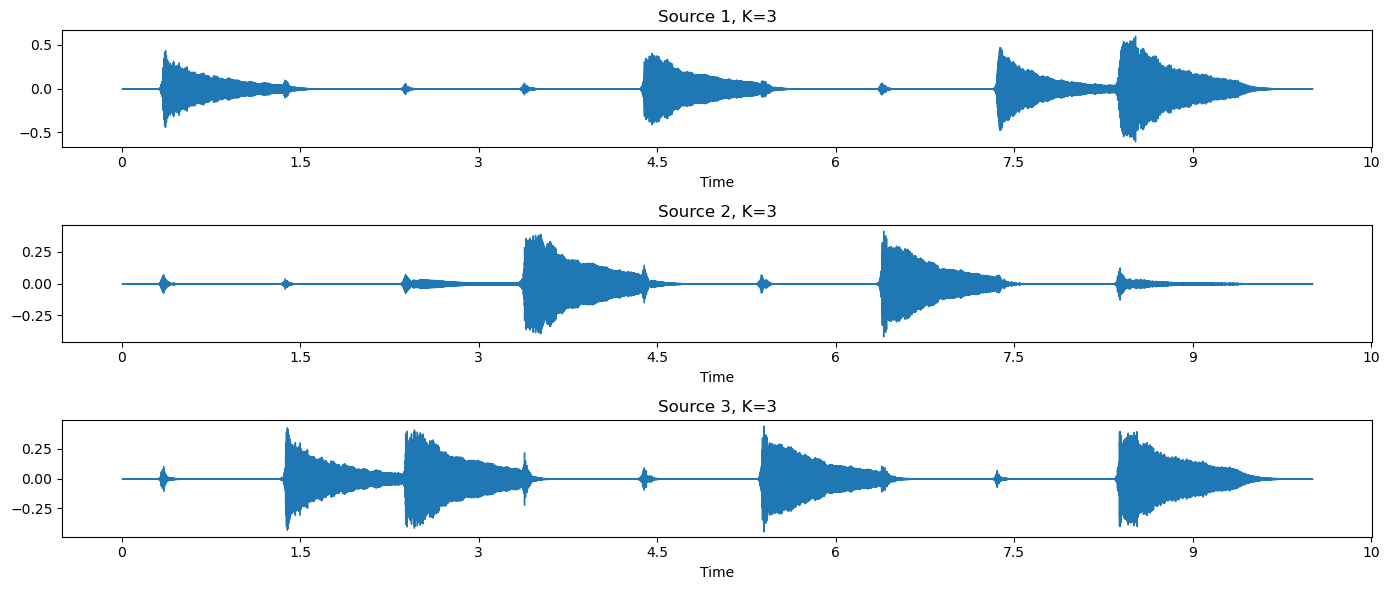

<Figure size 640x480 with 0 Axes>

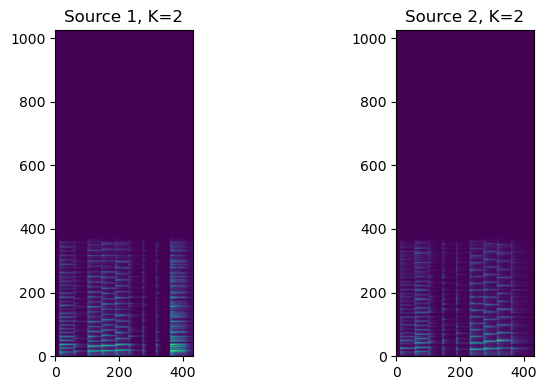

<Figure size 640x480 with 0 Axes>

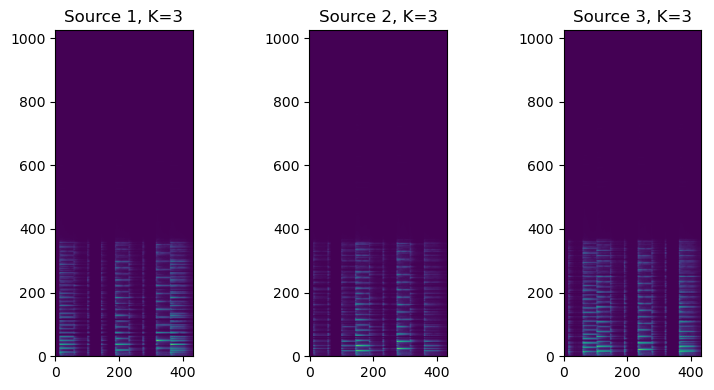

In [18]:
X_filtered = np.abs(X_filtered)
X_filtered1 = np.abs(X_filtered1)

# Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 6))
plt.subplot(2,1,1)
librosa.display.waveshow(y_filtered[0], sr=sr)
plt.title('Source 1, K=2')
plt.subplot(2,1,2)
librosa.display.waveshow(y_filtered[1], sr=sr)
plt.title('Source 2, K=2')
plt.tight_layout()
plt.show()

plt.figure()
plt.figure(figsize=(14, 6))
plt.subplot(3,1,1)
librosa.display.waveshow(y_filtered1[0], sr=sr)
plt.title('Source 1, K=3')
plt.subplot(3,1,2)
librosa.display.waveshow(y_filtered1[1], sr=sr)
plt.title('Source 2, K=3')
plt.subplot(3,1,3)
librosa.display.waveshow(y_filtered1[2], sr=sr)
plt.title('Source 3, K=3')
plt.tight_layout()
plt.show()

# Visualize the spectrums
plt.figure()
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(X_filtered[0]**0.3)
plt.gca().invert_yaxis()
plt.title('Source 1, K=2')
plt.subplot(1,2,2)
plt.imshow(X_filtered[1]**0.3)
plt.gca().invert_yaxis()
plt.title('Source 2, K=2')
plt.tight_layout()
plt.show()


plt.figure()
plt.figure(figsize=(8, 4))
plt.subplot(1,3,1)
plt.imshow(X_filtered1[0]**0.3)
plt.gca().invert_yaxis()
plt.title('Source 1, K=3')
plt.subplot(1,3,2)
plt.imshow(X_filtered1[1]**0.3)
plt.gca().invert_yaxis()
plt.title('Source 2, K=3')
plt.subplot(1,3,3)
plt.imshow(X_filtered1[2]**0.3)
plt.gca().invert_yaxis()
plt.title('Source 3, K=3')
plt.tight_layout()
plt.show()


From the previous analysis, we have seen that the number of columns of W is related to the number of sources in the mixture (in this case of application).

2. Using number of sources = 8, $\beta = 1$ (Kullback-Leibler divergence), and comparing results changing STFT windowed signal size = {2048,1024} with STFT hop size = {512,128} respectively.

Following the idea of the previous analysis, we have seen that the number of columns in W is related to the number of sources (in the mixture in this case of application). So this experiment tries to illustrate how having a bigger window size can help to improve the separation of the sources, by taking advantage of a better frequency resolution. This comes with a cost, we lose temporal resolution, but in this case it is not a problem because the notes are long enough to be separated.

For doing this we chose 8 sources that represents the 8 diferent notes of the piano signal, in the analysis we ignore the last sound that is a combination of the previous ones.

In [19]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT window size 2048
Xstft = librosa.stft(y, n_fft=2048, hop_length=512)
# Compute magnitude spectrogram
X = np.abs(Xstft)

# Compute STFT window size 1024
Xstft1 = librosa.stft(y, n_fft=512, hop_length=128)
# Compute magnitude spectrogram
X1 = np.abs(Xstft1)

In [20]:
# Compute de W, H factorization
W, H = MUR_NMF(X, 8, 1, max_iter=100)

# Compute the filtered spectrogram
X_filtered = Wiener_filtering(Xstft, W, H)

# Compute de W, H factorization
W, H = MUR_NMF(X1, 8, 1, max_iter=100)

# Compute the filtered spectrogram
X_filtered1 = Wiener_filtering(Xstft1, W, H)

y_filtered = []
# Compute the inverse stft for each signal
for i in range(X_filtered.shape[0]):
    y_filtered.append(librosa.istft(X_filtered[i]))
y_filtered = np.array(y_filtered)

y_filtered1 = []
# Compute the inverse stft for each signal
for i in range(X_filtered1.shape[0]):
    y_filtered1.append(librosa.istft(X_filtered1[i], n_fft=512, hop_length=128))
y_filtered1 = np.array(y_filtered1)

<Figure size 640x480 with 0 Axes>

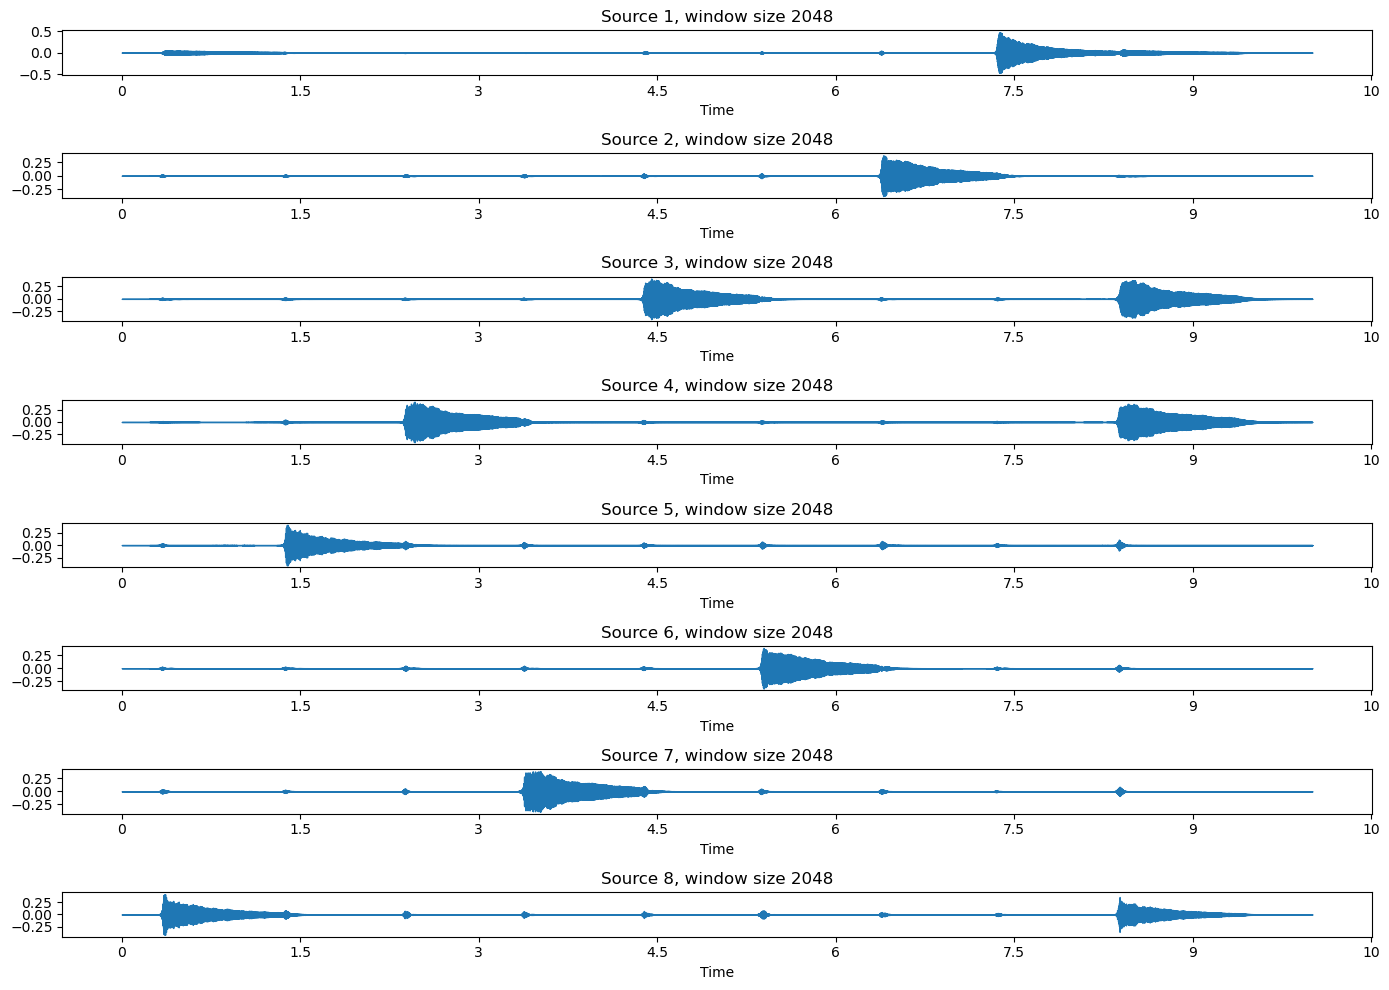

<Figure size 640x480 with 0 Axes>

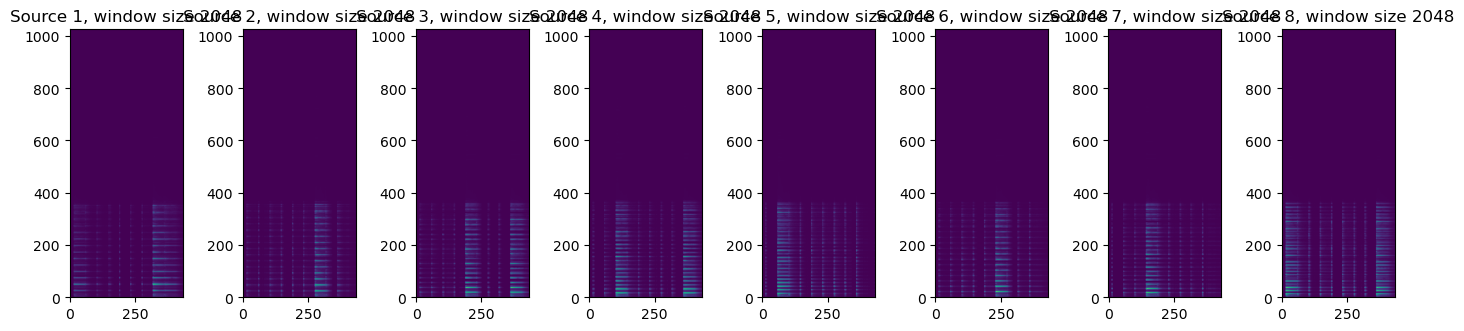

<Figure size 640x480 with 0 Axes>

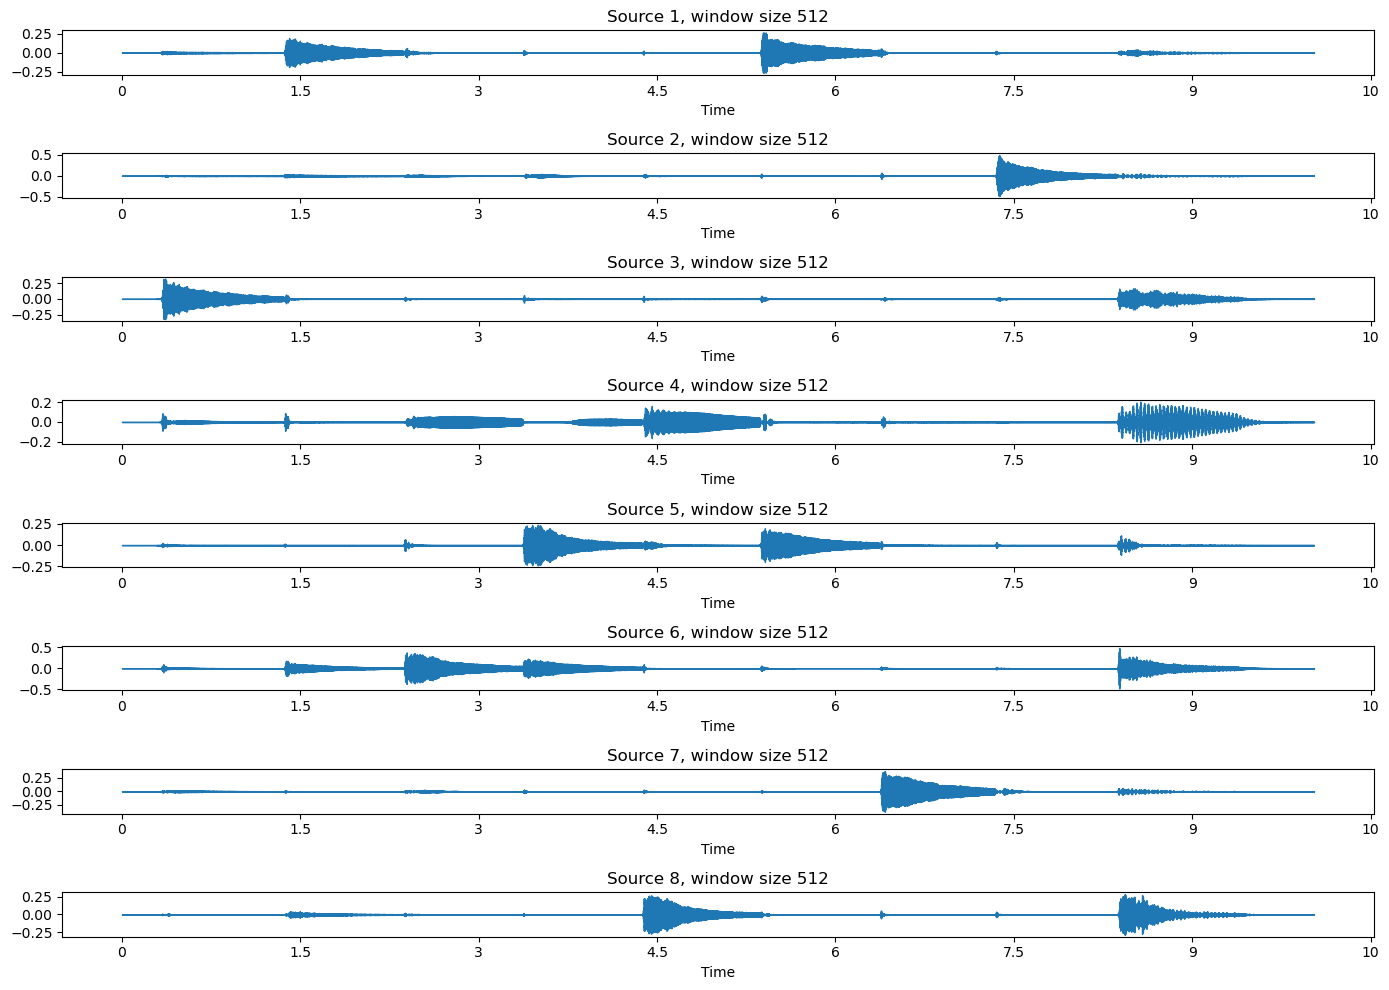

<Figure size 640x480 with 0 Axes>

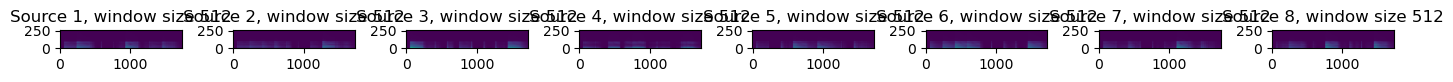

In [21]:
X_filtered = np.abs(X_filtered)
X_filtered1 = np.abs(X_filtered1)

# Plot the filtered waveform together  
plt.figure()
plt.figure(figsize=(14, 10)) 
for i in range(X_filtered.shape[0]):
    plt.subplot(X_filtered.shape[0],1,i+1)
    librosa.display.waveshow(y_filtered[i], sr=sr)
    plt.title('Source ' + str(i+1) + ', window size 2048')
plt.tight_layout()
plt.show()
    

# Plot the spectrogram of the filtered signal
plt.figure()
plt.figure(figsize=(14, 5))
for i in range(X_filtered.shape[0]):
    plt.subplot(1,X_filtered.shape[0],i+1)
    plt.imshow(X_filtered[i]**0.3)
    plt.gca().invert_yaxis()
    plt.title('Source ' + str(i+1) + ', window size 2048')
plt.tight_layout()
plt.show()



# Plot the filtered waveform together
plt.figure()
plt.figure(figsize=(14, 10))
for i in range(X_filtered1.shape[0]):
    plt.subplot(X_filtered1.shape[0],1,i+1)
    librosa.display.waveshow(y_filtered1[i], sr=sr)
    plt.title('Source ' + str(i+1) + ', window size 512')
plt.tight_layout()
plt.show()



# Plot the spectrogram of the filtered signal
plt.figure()
plt.figure(figsize=(14, 5))
for i in range(X_filtered1.shape[0]):
    plt.subplot(1,X_filtered1.shape[0],i+1)
    plt.imshow(X_filtered1[i]**0.3)
    plt.gca().invert_yaxis()
    plt.title('Source ' + str(i+1) + ', window size 512')
plt.tight_layout()
plt.show()


We can see that the separation is better when the window size is bigger, as for each source there is only one note displayed (and eventually the last sound). However with a smaller window size, the separation is not as good, as for each source there are more than one note displayed.

3. Using number of columns of W = 8, STFT window size = 2048, STFT hop size = 512, comparing results when changing $\beta$ = 10.

Follow the train of thought of the previous analysis, we will analyse in this case what changes if we change the $\beta$ parameter.

In [22]:
# Compute de W, H factorization
W, H = MUR_NMF(X, 8, 10, max_iter=100)

# Compute the filtered spectrogram
X_filtered = Wiener_filtering(Xstft, W, H)


y_filtered = []
# Compute the inverse stft for each signal
for i in range(X_filtered.shape[0]):
    y_filtered.append(librosa.istft(X_filtered[i]))
y_filtered = np.array(y_filtered)

<Figure size 640x480 with 0 Axes>

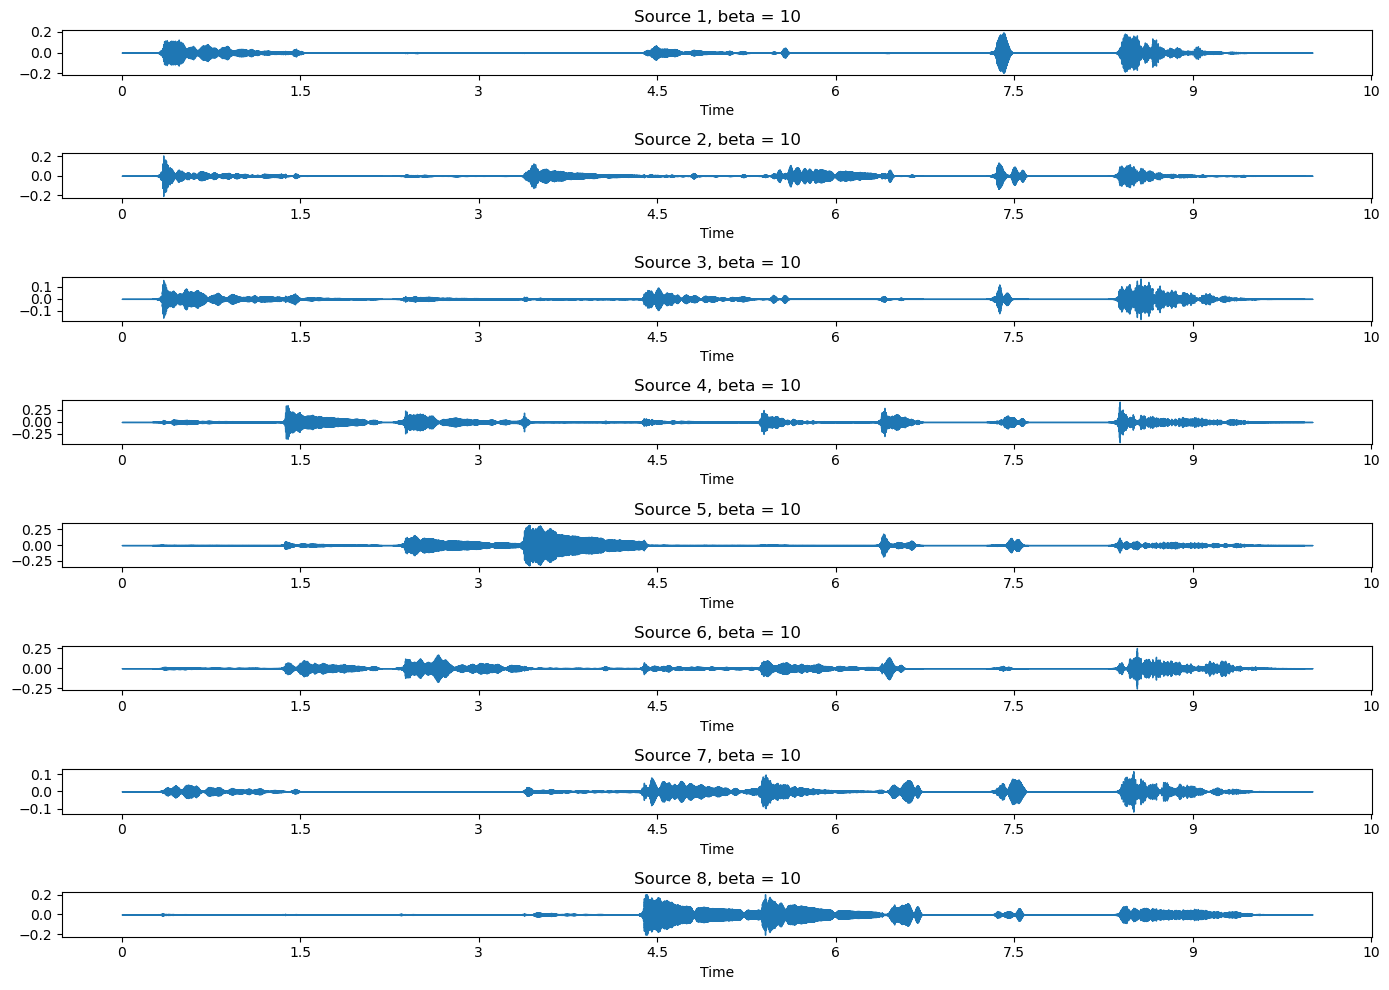

<Figure size 640x480 with 0 Axes>

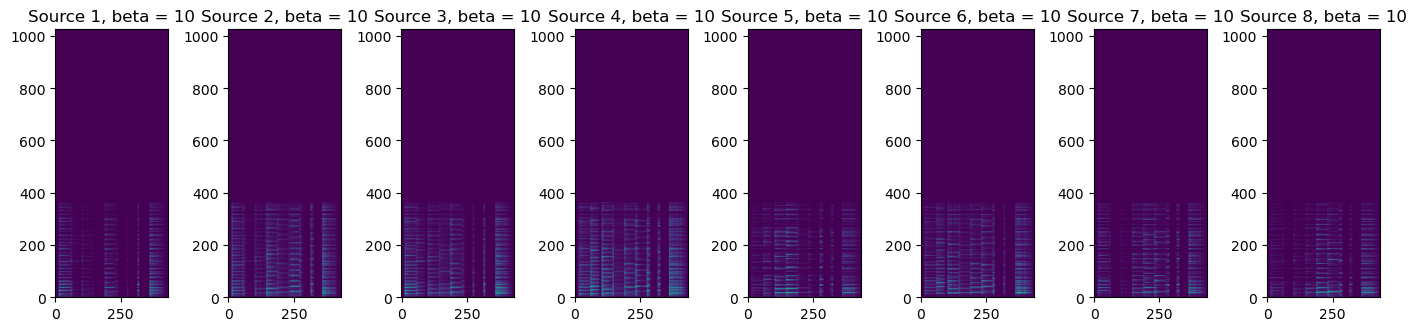

In [23]:
X_filtered = np.abs(X_filtered)
X_filtered1 = np.abs(X_filtered1)


# Plot the filtered waveform together
plt.figure()
plt.figure(figsize=(14, 10))
for i in range(X_filtered.shape[0]):
    plt.subplot(X_filtered.shape[0],1,i+1)
    librosa.display.waveshow(y_filtered[i], sr=sr)
    plt.title('Source ' + str(i+1) + ', beta = 10')
plt.tight_layout()
plt.show()


# Plot the spectrogram of the filtered signal
plt.figure()
plt.figure(figsize=(14, 5))
for i in range(X_filtered.shape[0]):
    plt.subplot(1,X_filtered.shape[0],i+1)
    plt.imshow(X_filtered[i]**0.3)
    plt.gca().invert_yaxis()
    plt.title('Source ' + str(i+1) + ', beta = 10')
plt.tight_layout()
plt.show()

The obtained results are much worst with this chose of $\beta$ parameter, as we can see in the plots, the separation is not good at all, and the sources are not well represented. The value of beta affects the convergence behavior of the NMF algorithm. Different values of beta can lead to variations in the convergence rate and the quality of the factorization. The value of beta is application dependent. In this case, the value of beta is not well chosen, and the results are not good.

### Conclusions:

From the experiments we can deduce that the non-negative matrix factorization is working as expected and we showed that it can be used for separating sources, but it is very sensitive to the parameters chosen. These parameters chosen are related to the application, and the knowledge of the data. For example in this case, we have seen that the number of columns of W is related to the number of sources in the mixture.